# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni computers (computer rooms DM.0.07, DM.0.13, DM.0.17, DM.0.21) according to the README.MD instructions without ANY exceptions: 3pt
2. Perfect 1:1 reproducibility on those machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**The main reason why we mention the machines in the uni computer rooms is to make it clear to you how we will test your submissions and to make you aware that you can use these machines for working on your assignment if you do not have access to a computer with enough gpu. You do not have to use these machines for this assignment. Using the specified pytorch version, not enabling torch.backends.cuda.matmul.allow_tf32, setting fixed seeds and making sure your code doesn't use more than 8gb VRAM should allow you to fulfill the reproducibility criteria.**

**(If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email)**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test". 

We can see that the majority of images have a height or width of 256 pixels, so we tried resizing to 256x256. However, this was using too much memory so **we will resize all images to be 128x128**.
The CNN will need inputs of the same size.

In [1]:
import os
import cv2                        # to load the images
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # for the data augmentation
from sklearn.model_selection import train_test_split   # For making the validation data set
from tqdm import tqdm
from pathlib import Path     # for the directory names for the labels
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter


os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(torch.__version__)

2025-05-15 17:43:39.137480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 17:43:39.144943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747323819.153187 1903098 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747323819.155817 1903098 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747323819.162692 1903098 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.6.0+cu124


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
if torch.cuda.is_available():
    gpu_id = torch.cuda.current_device()
    total_mem = torch.cuda.get_device_properties(gpu_id).total_memory / 1024**3  # 转为 GB
    reserved_mem = torch.cuda.memory_reserved(gpu_id) / 1024**3
    allocated_mem = torch.cuda.memory_allocated(gpu_id) / 1024**3
    free_mem = reserved_mem - allocated_mem

    print(f"🔍 GPU Info (device {gpu_id}):")
    print(f"  Total memory:     {total_mem:.2f} GB")
    print(f"  Reserved memory:  {reserved_mem:.2f} GB")
    print(f"  Allocated memory: {allocated_mem:.2f} GB")
    print(f"  Free memory:      {free_mem:.2f} GB (inside reserved)")
else:
    print("❌ CUDA is not available.")


🔍 GPU Info (device 0):
  Total memory:     7.75 GB
  Reserved memory:  0.00 GB
  Allocated memory: 0.00 GB
  Free memory:      0.00 GB (inside reserved)


Classes: ['beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad

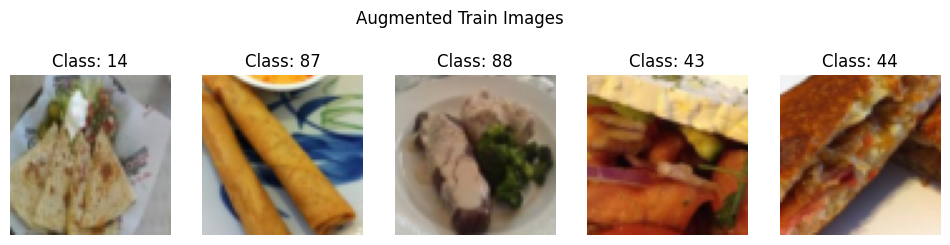

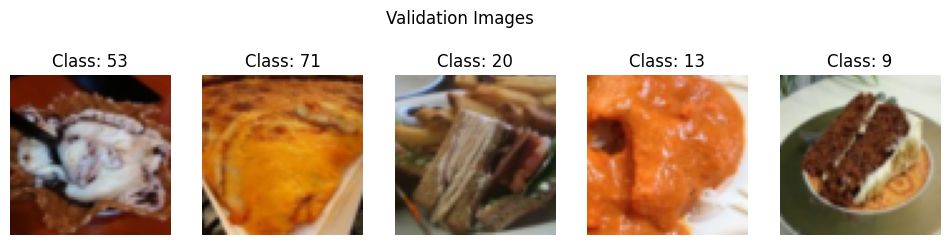

In [3]:
# Set image size
img_size = 64
batch_size = 128

# Define data augmentation transforms (for training set only)
train_transform = transforms.Compose([
    transforms.Resize((img_size + 32, img_size + 32)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),                 # Random horizontal flip
    transforms.RandomRotation(degrees=10),                  # Random rotation within ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                                  # Convert to tensor & normalize to [0,1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)          # Standardize to [-1, 1]
])

# Define validation/test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((img_size + 32, img_size + 32)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load data using ImageFolder
train_dataset_full = datasets.ImageFolder(root='./train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./test', transform=val_transform)

# Split into training and validation datasets (90% / 10%)
val_ratio = 0.1
val_size = int(len(train_dataset_full) * val_ratio)
train_size = len(train_dataset_full) - val_size

g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size], generator=g)

# Replace validation transform to ensure no augmentation is applied
val_dataset.dataset.transform = val_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

print(f"Classes: {train_dataset.dataset.classes}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")

# Visualize a few images
def show_images(dataset, num_images=5, title=""):
    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()         # Convert from CHW to HWC
        image = (image * 0.5) + 0.5                    # Unnormalize: [-1,1] → [0,1]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Visualize training images (with augmentation)
show_images(train_dataset, title="Augmented Train Images")

# Visualize validation images (no augmentation)
show_images(val_dataset, title="Validation Images")


# CNN Implementation

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(identity)

        out += identity
        return self.relu(out)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FoodCNN(nn.Module):
    def __init__(self, num_classes, image_size):
        super(FoodCNN, self).__init__()
        
        self.img_size = image_size  # ✅ Store image size for internal use

        self.block1 = nn.Sequential(
            ResidualBlock(3, 64),
            ResidualBlock(64, 64)
        )
        
        self.dropout1 = nn.Dropout(0.3)
        
        self.block2 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128)
        )
        
        self.dropout2 = nn.Dropout(0.4)
        
        self.block3 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256)
        )
        
        self.dropout3 = nn.Dropout(0.5)
        
        self.block4 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512)
        )
                
        # flattened_size = self._get_flattened_size()
        # print("Flattened size:", flattened_size)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
    # def _get_flattened_size(self):
    #     with torch.no_grad():
    #         dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
    #         x = self.block1(dummy_input)
    #         x = self.block2(x)
    #         x = self.block3(x)
    #         x = self.block4(x)
    #         return x.view(1, -1).size(1)
    # def _get_flattened_size(self):
    #     with torch.no_grad():
    #         dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)  # Change img_size dynamically
    #         x = self.block1(dummy_input)
    #         print(f"After block1: {x.shape}")
    #         x = self.block2(x)
    #         print(f"After block2: {x.shape}")
    #         x = self.block3(x)
    #         print(f"After block3: {x.shape}")
    #         x = self.block4(x)
    #         print(f"After block4: {x.shape}")
    #         x = self.block5(x)
    #         print(f"After block5: {x.shape}")
    #         return x.view(1, -1).size(1)  # Flatten and return the size

            
    def forward(self, x):
        x = self.block1(x)
        x = self.dropout1(x)
    
        x = self.block2(x)
        x = self.dropout2(x)
    
        x = self.block3(x)
        x = self.dropout3(x)
    
        x = self.block4(x)
    
        x = self.classifier(x)
        return x


# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [6]:
# set a fixed seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# make sure CUDA use deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print('cuda' if torch.cuda.is_available() else 'cpu')
# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now you can move the model to the appropriate device
num_classes = len(train_dataset.dataset.classes)
model = FoodCNN(num_classes=num_classes, image_size=img_size).to(device)

# Optimizer and criterion can remain the same
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # 'max' means we reduce the LR when validation accuracy stops increasing
    factor=0.3,  # The factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7  # Minimum learning rate to avoid going to zero
)

cuda


In [7]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score <= self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

# Training function with tqdm progress bar
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Using tqdm to show progress of each batch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", ncols=100)
    
    for i, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        # avoid exploding gradients by limiting the maximum norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm progress bar with loss and accuracy
        progress_bar.set_postfix(loss=running_loss / (i + 1), accuracy=100 * correct / total)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

# Validation function with tqdm progress bar
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Using tqdm to show progress of each batch in validation
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", ncols=100)
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update tqdm progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss / (i + 1), accuracy=100 * correct / total)
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def load_checkpoint(model, optimizer, scheduler, path='checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, scheduler, start_epoch

early_stopping = EarlyStopping(patience=10, verbose=True)

# If resuming in the same session, start from wherever you reached before:
start_epoch = 0
num_epochs = 100

# If you had restarted and want to resume from checkpoint:
# model, optimizer, scheduler, start_epoch = load_checkpoint(model, optimizer, scheduler) # , path=...

lr_list =[]
best_val_acc = 0
checkpoint_path = 'checkpoint.pth'

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)
    
    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
    
    # Step the learning rate scheduler based on validation accuracy
    scheduler.step(val_acc)  # Pass in validation accuracy to monitor
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

        
    # print the learing rate to check it
    current_lr = optimizer.param_groups[0]['lr']
    lr_list.append(current_lr)
    print(f"Current learning rate: {current_lr:.6f}")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'total_epochs_without_improvement': early_stopping.counter,
        'best_score': early_stopping.best_score
    }, checkpoint_path)

    torch.cuda.empty_cache()


Epoch 1 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 10.93it/s, accuracy=9.38, loss=4.05]


Epoch [1/100]
Train Loss: 4.0603, Train Accuracy: 8.14%
Val Loss: 4.0525, Val Accuracy: 9.38%
Current learning rate: 0.000100


Epoch 2 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 10.96it/s, accuracy=15.7, loss=3.61]


Epoch [2/100]
Train Loss: 3.6562, Train Accuracy: 14.61%
Val Loss: 3.6142, Val Accuracy: 15.75%
Current learning rate: 0.000100


Epoch 3 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 11.03it/s, accuracy=17.1, loss=3.54]


Epoch [3/100]
Train Loss: 3.3772, Train Accuracy: 19.56%
Val Loss: 3.5440, Val Accuracy: 17.15%
Current learning rate: 0.000100


Epoch 4 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=20.5, loss=3.37]


Epoch [4/100]
Train Loss: 3.1795, Train Accuracy: 23.35%
Val Loss: 3.3748, Val Accuracy: 20.45%
Current learning rate: 0.000100


Epoch 5 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 11.00it/s, accuracy=22.9, loss=3.28]


Epoch [5/100]
Train Loss: 3.0159, Train Accuracy: 26.68%
Val Loss: 3.2830, Val Accuracy: 22.94%
Current learning rate: 0.000100


Epoch 6 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 10.98it/s, accuracy=23.7, loss=3.23]


Epoch [6/100]
Train Loss: 2.8793, Train Accuracy: 29.38%
Val Loss: 3.2304, Val Accuracy: 23.73%
Current learning rate: 0.000100


Epoch 7 Validation: 100%|██████████████████| 36/36 [00:03<00:00, 11.04it/s, accuracy=24.3, loss=3.2]


Epoch [7/100]
Train Loss: 2.7554, Train Accuracy: 31.79%
Val Loss: 3.1970, Val Accuracy: 24.26%
Current learning rate: 0.000100


Epoch 8 Validation: 100%|███████████████████| 36/36 [00:03<00:00, 10.98it/s, accuracy=32, loss=2.81]


Epoch [8/100]
Train Loss: 2.6299, Train Accuracy: 34.59%
Val Loss: 2.8069, Val Accuracy: 31.96%
Current learning rate: 0.000100


Epoch 9 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=27.4, loss=3.21]


Epoch [9/100]
Train Loss: 2.5094, Train Accuracy: 37.20%
Val Loss: 3.2133, Val Accuracy: 27.38%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000100


Epoch 10 Validation: 100%|██████████████████| 36/36 [00:03<00:00, 10.86it/s, accuracy=35, loss=2.66]


Epoch [10/100]
Train Loss: 2.4082, Train Accuracy: 39.52%
Val Loss: 2.6570, Val Accuracy: 35.00%
Current learning rate: 0.000100


Epoch 11 Validation: 100%|██████████████████| 36/36 [00:03<00:00, 10.89it/s, accuracy=36, loss=2.59]


Epoch [11/100]
Train Loss: 2.3066, Train Accuracy: 41.92%
Val Loss: 2.5863, Val Accuracy: 35.98%
Current learning rate: 0.000100


Epoch 12 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.89it/s, accuracy=33.2, loss=2.81]


Epoch [12/100]
Train Loss: 2.2080, Train Accuracy: 44.20%
Val Loss: 2.8145, Val Accuracy: 33.16%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000100


Epoch 13 Validation: 100%|██████████████████| 36/36 [00:03<00:00, 11.03it/s, accuracy=38, loss=2.53]


Epoch [13/100]
Train Loss: 2.1117, Train Accuracy: 46.43%
Val Loss: 2.5327, Val Accuracy: 38.01%
Current learning rate: 0.000100


Epoch 14 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.00it/s, accuracy=33.3, loss=2.87]


Epoch [14/100]
Train Loss: 2.0298, Train Accuracy: 48.29%
Val Loss: 2.8749, Val Accuracy: 33.33%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000100


Epoch 15 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.96it/s, accuracy=34.5, loss=2.74]


Epoch [15/100]
Train Loss: 1.9494, Train Accuracy: 49.92%
Val Loss: 2.7372, Val Accuracy: 34.47%
EarlyStopping counter: 2 out of 10
Current learning rate: 0.000100


Epoch 16 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=42.3, loss=2.34]


Epoch [16/100]
Train Loss: 1.8733, Train Accuracy: 52.01%
Val Loss: 2.3419, Val Accuracy: 42.26%
Current learning rate: 0.000100


Epoch 17 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=43.6, loss=2.31]


Epoch [17/100]
Train Loss: 1.7998, Train Accuracy: 53.67%
Val Loss: 2.3066, Val Accuracy: 43.61%
Current learning rate: 0.000100


Epoch 18 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=38.4, loss=2.52]


Epoch [18/100]
Train Loss: 1.7260, Train Accuracy: 55.58%
Val Loss: 2.5230, Val Accuracy: 38.39%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000100


Epoch 19 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.86it/s, accuracy=40.9, loss=2.51]


Epoch [19/100]
Train Loss: 1.6593, Train Accuracy: 56.71%
Val Loss: 2.5089, Val Accuracy: 40.94%
EarlyStopping counter: 2 out of 10
Current learning rate: 0.000100


Epoch 20 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 10.89it/s, accuracy=40.2, loss=2.5]


Epoch [20/100]
Train Loss: 1.5868, Train Accuracy: 58.56%
Val Loss: 2.5028, Val Accuracy: 40.16%
EarlyStopping counter: 3 out of 10
Current learning rate: 0.000030


Epoch 21 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.71it/s, accuracy=48.8, loss=2.06]


Epoch [21/100]
Train Loss: 1.3083, Train Accuracy: 66.33%
Val Loss: 2.0593, Val Accuracy: 48.84%
Current learning rate: 0.000030


Epoch 22 Validation: 100%|█████████████████| 36/36 [00:03<00:00, 11.04it/s, accuracy=47.7, loss=2.1]


Epoch [22/100]
Train Loss: 1.2301, Train Accuracy: 68.72%
Val Loss: 2.1020, Val Accuracy: 47.73%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000030


Epoch 23 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.77it/s, accuracy=47.7, loss=2.12]


Epoch [23/100]
Train Loss: 1.1773, Train Accuracy: 69.89%
Val Loss: 2.1209, Val Accuracy: 47.66%
EarlyStopping counter: 2 out of 10
Current learning rate: 0.000030


Epoch 24 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.91it/s, accuracy=49.7, loss=2.08]


Epoch [24/100]
Train Loss: 1.1384, Train Accuracy: 70.78%
Val Loss: 2.0758, Val Accuracy: 49.65%
Current learning rate: 0.000030


Epoch 25 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.15it/s, accuracy=48.2, loss=2.17]


Epoch [25/100]
Train Loss: 1.0930, Train Accuracy: 72.32%
Val Loss: 2.1715, Val Accuracy: 48.23%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000030


Epoch 26 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.15it/s, accuracy=50.9, loss=2.01]


Epoch [26/100]
Train Loss: 1.0532, Train Accuracy: 73.53%
Val Loss: 2.0139, Val Accuracy: 50.90%
Current learning rate: 0.000030


Epoch 27 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.97it/s, accuracy=48.4, loss=2.11]


Epoch [27/100]
Train Loss: 1.0154, Train Accuracy: 74.33%
Val Loss: 2.1124, Val Accuracy: 48.43%
EarlyStopping counter: 1 out of 10
Current learning rate: 0.000030


Epoch 28 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.02it/s, accuracy=48.7, loss=2.12]


Epoch [28/100]
Train Loss: 0.9762, Train Accuracy: 75.33%
Val Loss: 2.1171, Val Accuracy: 48.67%
EarlyStopping counter: 2 out of 10
Current learning rate: 0.000030


Epoch 29 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.14it/s, accuracy=50.3, loss=2.03]


Epoch [29/100]
Train Loss: 0.9404, Train Accuracy: 76.50%
Val Loss: 2.0289, Val Accuracy: 50.26%
EarlyStopping counter: 3 out of 10
Current learning rate: 0.000009


Epoch 30 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.07it/s, accuracy=49.8, loss=2.03]


Epoch [30/100]
Train Loss: 0.8287, Train Accuracy: 80.16%
Val Loss: 2.0342, Val Accuracy: 49.85%
EarlyStopping counter: 4 out of 10
Current learning rate: 0.000009


Epoch 31 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.96it/s, accuracy=50.2, loss=2.04]


Epoch [31/100]
Train Loss: 0.8013, Train Accuracy: 81.07%
Val Loss: 2.0382, Val Accuracy: 50.17%
EarlyStopping counter: 5 out of 10
Current learning rate: 0.000009


Epoch 32 Validation: 100%|████████████████| 36/36 [00:03<00:00, 11.01it/s, accuracy=50.8, loss=2.04]


Epoch [32/100]
Train Loss: 0.7809, Train Accuracy: 81.66%
Val Loss: 2.0390, Val Accuracy: 50.83%
EarlyStopping counter: 6 out of 10
Current learning rate: 0.000003


Epoch 33 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.96it/s, accuracy=50.7, loss=2.04]


Epoch [33/100]
Train Loss: 0.7428, Train Accuracy: 83.12%
Val Loss: 2.0360, Val Accuracy: 50.70%
EarlyStopping counter: 7 out of 10
Current learning rate: 0.000003


Epoch 34 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.89it/s, accuracy=50.9, loss=2.02]


Epoch [34/100]
Train Loss: 0.7348, Train Accuracy: 83.25%
Val Loss: 2.0220, Val Accuracy: 50.85%
EarlyStopping counter: 8 out of 10
Current learning rate: 0.000003


Epoch 35 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.90it/s, accuracy=50.5, loss=2.02]


Epoch [35/100]
Train Loss: 0.7278, Train Accuracy: 83.36%
Val Loss: 2.0158, Val Accuracy: 50.50%
EarlyStopping counter: 9 out of 10
Current learning rate: 0.000001


Epoch 36 Validation: 100%|████████████████| 36/36 [00:03<00:00, 10.84it/s, accuracy=50.2, loss=2.05]

Epoch [36/100]
Train Loss: 0.7170, Train Accuracy: 83.92%
Val Loss: 2.0471, Val Accuracy: 50.20%
EarlyStopping counter: 10 out of 10
Early stopping triggered.


Start from checkpoint

In [ ]:
model = FoodCNN(num_classes=num_classes, image_size=img_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4) # change the learning rate here 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)
criterion = nn.CrossEntropyLoss()
start_epoch = 0 

checkpoint_path = 'checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")
else:
    print("No checkpoint found, training from scratch.")

for epoch in range(start_epoch, num_epochs):
    # Training phase
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)

    # Validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)

    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Scheduler and early stopping
    scheduler.step(val_acc)
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # print the learing rate to check it
    current_lr = optimizer.param_groups[0]['lr']
    lr_list.append(current_lr)
    print(f"Current learning rate: {current_lr:.6f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'total_epochs_without_improvement': early_stopping.counter,
        'best_score': early_stopping.best_score
    }, checkpoint_path)

    torch.cuda.empty_cache()


# Calculating model performance
Load the best version of your model ( which should be produced and saved by previous cells ), calculate and report the test accuracy.

In [8]:
# Load the best model weights
model = FoodCNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))

final_test_acc = calculate_test_accuracy(model)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")


TypeError: __init__() missing 2 required positional arguments: 'num_classes' and 'image_size'

# Summary of hyperparameters
Report the hyperparameters ( learning rate etc ) that you used in your final model for reproducibility.

# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

In [ ]:
# Your code here
# Below an example showing the format of the code output

# Bonus point
Use an LLM (API) to generate a description of the food preference of a user based on 10 images that a potential user could provide. 
Please include an example of the output of your code, especially if you used an API other than the OpenAI API.

This should work well even with differing test images by setting different random seeds for the image selector.